# DOPP 2020W Exercise 2

### Before you get started, please read the instructions in this notebook carefully.

## Preliminaries

- Please use only Python **version 3** (3.6+ recommended). It is recommended to run the notebook on the JupyterHub. 

- This notebook will be scored using [nbgrader](https://nbgrader.readthedocs.io/en/stable/user_guide/highlights.html). 
- Please use the code stubs provided, do not rename any functions, and add and modify your code only at the provided markers. 
- Check and make sure that your submission executes without any errors on the JupyterHub before submitting it. Submissions that don't execute will not be accepted.
- do not change cell tags as this may mess up the Validation and auto-grading features.


The submission deadline is **03.12.2020 23:55.**

Sections marked with `# YOUR CODE HERE` must be used to implement the functionality.
Cells containing `YOUR ANSWER HERE` must be used to fill in textual answers.

There is a total of 100 points that can be reached.

In [154]:
# Note: The only imports allowed are those contained in Python's standard library, pandas, numpy, scipy and matplotlib
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import glob
import matplotlib.pyplot as plt
import math
from math import sqrt

#add imports as needed
#import sklearn...
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Goal

In this exercise, you will 
 * use `pandas` to read, prepare and transform data,
 * use `matplotlib` to visually alayse data,
 * use `scikit-learn` to build prediction models.


The goal of this exercise is to model the relationship between weather observations and the prevalence of new influenza infections.

To investigate a potential relationship, we will use two datasets:
 * daily weather observation data in Vienna (2009-2019)
 * weekly reports on [new influenza infections](https://www.data.gv.at/katalog/dataset/grippemeldedienst-stadt-wien) in Vienna (2009-2019).

The data to be used can be found in the subdirectory named `data`. 

To complete this exercise, you will have to:
* prepare the data, which (at a minimum) involves the following:
    - handling missing values,
    - handling outliers
    - temporal alignment (i.e. convert daily data to weekly data using appropriate aggregation functions),
* analyse the data:
    - compare descriptive statistics,
    - visually investigate the raw data to gain an understanding of the data, identify patterns, outliers etc.,
    - look at the relationship between the variables of interest,
* model the relationship:
    - fit a model that predicts new infections from weather observation data.

## Task 1: Load Data

Total number of points for completing this task: **10**

### Weather observations

As a first step, implement the method `load_weather_data()`, which should read all individual (yearly) data sets from the csv files in `data` into a single `pd.DataFrame` and return it. 

- from the `date` column create `year`, `month`, `week`, `day` columns, where `week` contains the week number of the date. Use Pandas built-in datetime handling features.
- create a `MultiIndex` from the date columns with the following hierarchy: `year` - `month` - `week` - `day` (make sure to label them accordingly)
- make sure that all columns are appropriately typed
- make sure that you load all the data (2009-2019)

**Hints:**
 
 - LOOK at the data in the original files
 - It is advisable not to append each data set individually, but to read each data frame, store it into a list and  combine them once at the end.
 - Your resulting data frame should look as follows:

![Weather data frame example](weather_data_dataframe_sample.png)

In [121]:
def load_weather_data():
    """ 
    Load all weather data files and combine them into a single Pandas DataFrame.
    Add a week column and a hierarchical index (year, month, week, day)
    
    Returns
    --------
    weather_data: data frame containing the weather data
    """
    # YOUR CODE HERE
    dataframes = []
    for i in range(2009, 2020):
        dataframe = pd.read_csv('./data-corrected/data-corrected/weather/{}-ZAMG_Jahrbuch.csv'.format(str(i)), delimiter=";")
        dataframe['date'] = pd.to_datetime(dataframe['date']) 
        dataframe['year'] = dataframe['date'].dt.year
        dataframe['month'] = dataframe['date'].dt.month
        dataframe['week'] = dataframe['date'].dt.week
        dataframe['day'] = dataframe['date'].dt.day
        dataframe = dataframe.set_index(['year', 'month', 'week', 'day'])
        dataframe.sort_index(inplace=True)
        dataframes.append(dataframe)
    weather_data = pd.concat(dataframes)
    return weather_data
data_weather = load_weather_data()
data_weather

date  skyCover_7h  skyCover_14h  skyCover_19h  \
year month week day                                                       
2009 1     1    1   2009-01-01           10             5            10   
                2   2009-01-02           10             9            10   
                3   2009-01-03            3             5             1   
                4   2009-01-04            5             9             9   
           2    5   2009-01-05            9            10            10   
...                        ...          ...           ...           ...   
2019 12    52   25  2019-12-25           10             8            10   
                26  2019-12-26            4             8             9   
                27  2019-12-27            9             4             9   
                28  2019-12-28            9             8             9   
                29  2019-12-29           10            10             9   

                     temp_7h  temp_14h  temp_19h  temp_dailyMean  \
year month week day                                                
2009 1     1    1       -4.5      -0.1      -1.8            -2.4   
                2       -3.0      -1.3      -1.7            -2.2   
                3       -4.8      -1.7      -3.9            -3.7   
                4       -3.8      -0.2      -0.5            -3.7   
           2    5       -0.7      -0.6      -1.3            -0.7   
...                      ...       ...       ...             ...   
2019 12    52   25       7.7       9.3       6.7             7.4   
                26       5.0       6.8       5.7             5.9   
                27       3.6       6.5       4.7             4.8   
                28       2.2       2.5       1.5             3.0   
                29      40.0       1.1       0.8             1.0   

                     temp_dailyMax  temp_dailyMin  hum_7h  hum_14h  hum_19h  \
year month week day                                                           
2009 1     1    1              0.0           -4.7    79.0     71.0     72.0   
                2             -1.3           -3.1    67.0     66.0     68.0   
                3             -1.5           -5.9    83.0     70.0     70.0   
                4              0.2           -7.6    75.0     62.0     63.0   
           2    5              0.0           -1.4    64.0     76.0     80.0   
...                            ...            ...     ...      ...      ...   
2019 12    52   25            10.3            4.4    77.0     71.0     85.0   
                26             7.4            4.4    78.0     65.0     65.0   
                27             6.9            2.7    69.0     46.0     65.0   
                28             4.7            1.3    72.0     53.0     60.0   
                29             1.6            0.4    61.0     62.0     60.0   

                     windBeauf_7h  windBeauf_14h  windBeauf_19h  precip  
year month week day                                                      
2009 1     1    1               2              2              2       0  
                2               0              2              3  Spuren  
                3               2              2              2       0  
                4               4              4              3  Spuren  
           2    5               4              3              2  Spuren  
...                           ...            ...            ...     ...  
2019 12    52   25              4              4              4     2.4  
                26              4              3              2  Spuren  
                27              2              3              3     0.7  
                28              4              4              3  Spuren  
                29              4              3              2  Spuren  

[4017 rows x 17 columns]

In [62]:
assert data_weather.shape == (4017, 17)

# additional tests

Which combination of year+week has the highest number of entries? What causes this number? (You should find the respective entry/entries using pandas)

In [122]:
# fill your answer into these variables
year = 2012 
month = 1
# YOUR CODE HERE
max_combination = data_weather.groupby(['year','week']).size().sort_values(ascending=False).head(10)
print(max_combination)

# The highest number of entities in year and week combination is appearing 8. In real time situations we should be careful considering the fact that week has a maximum number of 7 entries. But in our case in my oppinion this is happening because in the dataframe we have the range for weeks from 1 to 52 and last dates 30/31 for some years are grouped as part of week 1 this might be due to convertation mistakes by python, since we where advised below in this assigment to keep it like that i didnt make any changes in this matter since out project is for study purposes, but in real life situations like this should be handled very carefuly.

year  week
2012  1       8
2019  1       8
2013  1       8
2012  52      8
2017  52      8
2018  1       8
2014  1       8
2011  52      8
2019  52      7
2012  36      7
dtype: int64


In [9]:
### Influenza infections
Load and prepare the second data set (`influenza.csv`), which contains the number of new influenza infections on a weekly basis, as follows:

- get rid of all columns except `Neuerkrankungen pro Woche`, `Jahr`, and `Kalenderwoche`
- rename `Neuerkrankungen pro Woche` to `weekly_infections`
- create a `MultiIndex` from the `Jahr` (→ `year`) and `Kalenderwoche` (→ `week`) columns
- make sure that all columns are appropriately typed
- remove rows with missing infection counts
- your resulting data frame should look as follows:

![Example data frame](influenza_data_dataframe_sample.png)

SyntaxError: invalid syntax (<ipython-input-9-db4211e0f647>, line 3)

In [129]:
def load_influenza_data():
    """ 
    Load and prepare the influenza data file
    
    Returns
    --------
    influenza_data: data frame containing the influenza data
    """
    # YOUR CODE HERE
    influenza_data = pd.read_csv('./data-corrected/data-corrected/influenza/influenza.csv')
    influenza_data = influenza_data[['Jahr', 'Kalenderwoche', 'Neuerkrankungen pro Woche']]
    influenza_data.columns = ['year', 'week', 'weekly_infections']
    influenza_data['week'] = influenza_data['week'].str.extract('(\d+)').astype(int)
    influenza_data = influenza_data.set_index(['year', 'week'])
    influenza_data = influenza_data[influenza_data.weekly_infections != '-']
    influenza_data['weekly_infections'] = influenza_data['weekly_infections'].astype(np.float64)
    return influenza_data

data_influenza = load_influenza_data()
data_influenza

weekly_infections
year week                   
2009 40               6600.0
     41               7100.0
     42               7700.0
     43               8300.0
     44               8600.0
...                      ...
2019 10               8900.0
     11               6200.0
     12               5500.0
     13               3900.0
     14               3300.0

[258 rows x 1 columns]

In [130]:
assert data_influenza.shape == (258, 1)
# additional tests

Which combination of year+week shows the highest number of infections?

In [147]:
# fill your answer into these variables
year = 2017
month = 1
highest_number = data_influenza.sort_values(by=['year','week',"weekly_infections"])
print(max_combination)

           weekly_infections
year week                   
2017 1               19700.0
     2               19200.0
2011 5               19200.0
2013 8               17000.0
2009 48              16800.0
2013 9               15800.0
2009 47              15800.0
2011 4               15600.0
2015 7               15400.0
2009 49              15300.0


In [ ]:
# hidden tests

## Task 2: Handling Missing Values

Total number of points for completing this task: **15**

If you take a closer look at the data, you will notice that a few of the observations are missing.

There are a wide range of standard strategies to deal with such missing values, including:

- row deletion
- substitution methods (e.g., replace with mean or median)
- hot-/cold-deck methods (impute from a randomly selected similar record)
- regression methods

To decide which strategy is appropriate, it is important to investigate the mechanism that led to the missing values to find out whether the missing data is missing completely at random, missing at random, or missing not at random. 

 - **MCAR** (Missing Completely At Random) means that there is no relationship between the missingness of the data and any of the values.
 - **MAR** (Missing At Random) means that that there is a systematic relationship between the propensity of missing values and the observed data, but not the missing data.
 - **MNAR** (Missing Not At Random) means that there is a systematic relationship between the propensity of a value to be missing and its values. 

To find out more about what mechanisms may have caused the missing values, you talked to the metereologist that compiled the data. 
She told you that she does not know why some of the temperature readings are missing, but that it may be that someone forgot to record them. In any case, it is likely that the propensity of a temperature value to be missing does not have anything to do with the weather itself.

As far as the missing humidity readings are concerned, she says that according to her experience, she suspects that the humidity sensor is less reliable in hot weather.

Check the plausibility of these hypotheses in the data, consider the implications, and devise an appropriate strategy to deal with the various missing values.

To implement your strategy, you can use a range of standard mechanisms provided by Pandas, by implementing `handle_missingValues_simple`, or implement a custom strategy (for extra points, by implementing `handle_missingValues_advanced`).

In [148]:
# YOUR CODE HERE
data_weather.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4017 entries, (2009, 1, 1, 1) to (2019, 12, 52, 29)
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            4017 non-null   datetime64[ns]
 1   skyCover_7h     4017 non-null   int64         
 2   skyCover_14h    4017 non-null   int64         
 3   skyCover_19h    4017 non-null   int64         
 4   temp_7h         4017 non-null   float64       
 5   temp_14h        4017 non-null   float64       
 6   temp_19h        4017 non-null   float64       
 7   temp_dailyMean  4017 non-null   float64       
 8   temp_dailyMax   4017 non-null   float64       
 9   temp_dailyMin   4017 non-null   float64       
 10  hum_7h          4017 non-null   float64       
 11  hum_14h         4017 non-null   float64       
 12  hum_19h         4017 non-null   float64       
 13  windBeauf_7h    4017 non-null   int64         
 14  windBeauf_14h   4017 non-nul

In [149]:
def handle_missingValues_simple(incomplete_data):
    """ 
    Parameters
    --------
    incomplete_data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame not containing any missing values
    """
    # YOUR CODE HERE
    missing_values_col = incomplete_data.columns[incomplete_data.isnull().any()].tolist()
    incomplete_data['precip'] = incomplete_data['precip'].replace('Spuren', '0.001')
    incomplete_data['precip'] = incomplete_data['precip'].astype(np.float64)
    for col in missing_values_col:
        incomplete_data[col] = incomplete_data[col].fillna(value=incomplete_data[col].median())
    complete_data = incomplete_data
    return complete_data


def handle_missingValues_advanced (incomplete_data):
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    data: data frame not containing any missing values
    """
    # YOUR CODE HERE
    missing_values_col = incomplete_data.columns[incomplete_data.isnull().any()].tolist()
    incomplete_data['precip'] = incomplete_data['precip'].replace('Spuren', '0.001')
    incomplete_data['precip'] = incomplete_data['precip'].astype(np.float64)
    null_data = incomplete_data[incomplete_data.isnull().any(axis=1)]
    not_null_data = incomplete_data.dropna()
    temp_null_data = null_data
    regressor = KNeighborsRegressor(n_neighbors = 9)
    
    
    for col in missing_values_col:
        temp_null_data = null_data
        temp_null_data = temp_null_data.drop(columns=['date'])
        Y_train = not_null_data[col]
        X_train = not_null_data.drop(columns=[col, 'date'])
        temp_null_data = temp_null_data.fillna(0)
        col_data = temp_null_data[col].copy()
        predict_data = temp_null_data.drop(columns=col)
        regressor.fit(X_train, Y_train)
        result = regressor.predict(predict_data)
        
        for index,item in enumerate(col_data):
            if item==0:
                col_data[index]= result[index]       
        null_data[col] = col_data             
    complete_data = pd.concat([not_null_data, null_data])
    return complete_data
    
data_weather_complete = handle_missingValues_advanced(data_weather)
data_weather_complete

date  skyCover_7h  skyCover_14h  skyCover_19h  \
year month week day                                                       
2009 1     1    1   2009-01-01           10             5            10   
                2   2009-01-02           10             9            10   
                3   2009-01-03            3             5             1   
                4   2009-01-04            5             9             9   
           2    5   2009-01-05            9            10            10   
...                        ...          ...           ...           ...   
2019 12    52   25  2019-12-25           10             8            10   
                26  2019-12-26            4             8             9   
                27  2019-12-27            9             4             9   
                28  2019-12-28            9             8             9   
                29  2019-12-29           10            10             9   

                     temp_7h  temp_14h  temp_19h  temp_dailyMean  \
year month week day                                                
2009 1     1    1       -4.5      -0.1      -1.8            -2.4   
                2       -3.0      -1.3      -1.7            -2.2   
                3       -4.8      -1.7      -3.9            -3.7   
                4       -3.8      -0.2      -0.5            -3.7   
           2    5       -0.7      -0.6      -1.3            -0.7   
...                      ...       ...       ...             ...   
2019 12    52   25       7.7       9.3       6.7             7.4   
                26       5.0       6.8       5.7             5.9   
                27       3.6       6.5       4.7             4.8   
                28       2.2       2.5       1.5             3.0   
                29      40.0       1.1       0.8             1.0   

                     temp_dailyMax  temp_dailyMin  hum_7h  hum_14h  hum_19h  \
year month week day                                                           
2009 1     1    1              0.0           -4.7    79.0     71.0     72.0   
                2             -1.3           -3.1    67.0     66.0     68.0   
                3             -1.5           -5.9    83.0     70.0     70.0   
                4              0.2           -7.6    75.0     62.0     63.0   
           2    5              0.0           -1.4    64.0     76.0     80.0   
...                            ...            ...     ...      ...      ...   
2019 12    52   25            10.3            4.4    77.0     71.0     85.0   
                26             7.4            4.4    78.0     65.0     65.0   
                27             6.9            2.7    69.0     46.0     65.0   
                28             4.7            1.3    72.0     53.0     60.0   
                29             1.6            0.4    61.0     62.0     60.0   

                     windBeauf_7h  windBeauf_14h  windBeauf_19h  precip  
year month week day                                                      
2009 1     1    1               2              2              2   0.000  
                2               0              2              3   0.001  
                3               2              2              2   0.000  
                4               4              4              3   0.001  
           2    5               4              3              2   0.001  
...                           ...            ...            ...     ...  
2019 12    52   25              4              4              4   2.400  
                26              4              3              2   0.001  
                27              2              3              3   0.700  
                28              4              4              3   0.001  
                29              4              3              2   0.001  

[4017 rows x 17 columns]

In [ ]:
# hidden tests

In [ ]:
# hidden tests

In [ ]:
# hidden tests

###  Discussion

#### Pros and Cons of strategies for dealing with missing data

In the cell provided below, discuss the PROs and CONs of various strategies (row deletion, imputation, hot deck methods etc.) for dealing with missing data. Discuss when it is appropriate to use each method.

Handling missing data is quite an important step before building models. There are two quite important and sufficient methods for this such as data deletation and data imputation. Both of them are quite used but taking into consideration the fact that all data values are important in order to get proper predictions i would not suggest the data deletation method since we lose information with that, but in cases where we have a big number of missings for a specific feature data deletation should be used because the data imputation in these cases can deter performance of the model we are building.

### Deletion

This technique can be done in two methods such as row deletation and column deletation.

#### Row Deletion

Row Deletation method deletes all data in a row where we have one or more missing values. We can use this method in cases where lots of data are missing in a specific row or if we know that the missing data is Missing completely at random (MCAR).
The concern for using this method is that we lose data that might have been important. But the advantage of this method is that is quite easy to implement and not at all computationally expensive. As per the cases of Missing completely at random (MCAR) its an assumption that is very rarely used.

#### Column Deletion

Column Deletation method deletes all data in a column where we have one or more missing values, its prefered that we delete an entire feature in cases where more than hald of the values in that column are missing. Its also a sensitive method like row deletation because of the fact that the data that we are deleting might be important data for the model we are trying to build. But as an advantage it can be that in some cases removing an entire column is better than imputing values in it because we avoid any potential bias which will lead to wrong prediction and reduce the accurance of the model. 

### Imputation

This technique can also be done in several forms such as imputation with mean/median, imputation with zero/most frequent value, hot deck methods or imputation with regression.

#### Imputation with mean/median

Imputation with mean/median method replaces all the missing values with the mean or the median of the specific feature. Its quite easy technique to be implemented and very practical comparing to other methods for imputation in term of computation costs.
A disadvantage of this method is that it does not know any correlation between features and its also complicated to be applied in categorical data.

#### Imputation with zero/most frequent value

Imputation with zero/most frequent value method replaces all the missing values with zero or with msot frequent value. Its also a simple method and quite computationally inexpensive to be implemented. Comparing to imputation with mean/median its more easy to be used in categorical data, but it has also the same disadvantage as imputation with mean/median which ignores any potential correlation in between features which can lead us to bias.

#### Hot Deck Methods

Hot Deck Method is imputation method which imputed the missing values by picking a randoom sample and replacing a missing value based on that sample.

#### Imputation with regression

Imputation with regression is a method for imputation of missing values which uses a model to do a prediction of values in data. Its a more accurate method comparing to the other ones but its important to note that it can be very computationally expensive depending on the prediction algorithm and the size of the data.

#### Your chosen strategy <span style="color:blue">

Explain your chosen strategy for dealing with missing values for the various attributes in the cell below.


First i did a check in the data to see in which features we have missing values, after the checking i was aware that we have missing values in temperature features and humidity features which needed to be handled. Since we know there are three categories of missing data such as MCAR, MAR, MNAR and since i am not sure which case is in the missing values of my dataset i decided not to implement any data deletation to prevent any loss of important information.
In this case i made two aproaches. A simple one where i imputed the missing values with the median of the particular feature where we have missings and a advanced method where i used a KNN regression method to build a model with 9 neighbours in order to predict the missing values. This method does firstly a seperation between missing values and not missing values then it uses the not missing values to predict the missing values. This is done through all the features where we have missings. And in the end we have a dataset with no missing values which where treated with KNN regression model. I would prefere and use the advanced method because it is more accurate that imputation with meadian my simple approach.  

## Task 3: Handling Outliers
Total number of points for completing this task: **15**

If you take a closer look at some of the observations, you should notice that some of the temperature values are not particularly plausible (hint: plotting histograms of the distributions helps). Hypothesize on the nature of these outliers and implement a strategy to handle them.

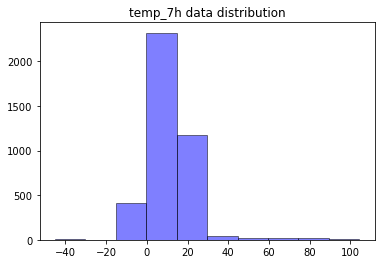

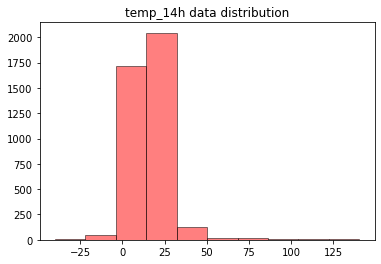

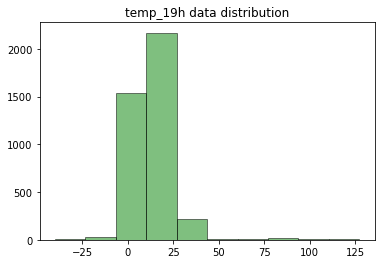

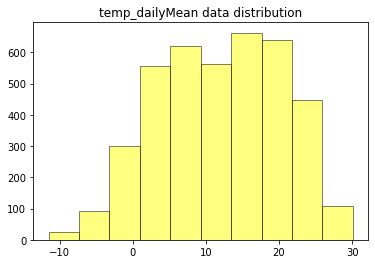

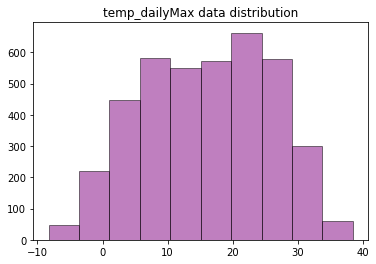

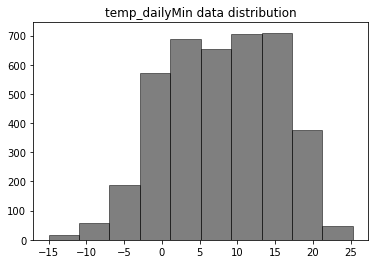

In [9]:
# YOUR CODE HERE
plt.figure(1)
plt.title('temp_7h data distribution')
hist_temp_7h = plt.hist(data_weather['temp_7h'], color = 'blue', edgecolor = 'black', alpha=0.5)
plt.figure(2)
plt.title('temp_14h data distribution')
hist_temp_14h = plt.hist(data_weather['temp_14h'], color = 'red', edgecolor = 'black', alpha=0.5)
plt.figure(3)
plt.title('temp_19h data distribution')
hist_temp_19h = plt.hist(data_weather['temp_19h'], color = 'green', edgecolor = 'black', alpha=0.5)
plt.figure(4)
plt.title('temp_dailyMean data distribution')
temp_dailyMean = plt.hist(data_weather['temp_dailyMean'], color = 'yellow', edgecolor = 'black', alpha=0.5)
plt.figure(5)
plt.title('temp_dailyMax data distribution')
temp_dailyMax = plt.hist(data_weather['temp_dailyMax'], color = 'purple', edgecolor = 'black', alpha=0.5)
plt.figure(6)
plt.title('temp_dailyMin data distribution')
temp_dailyMin = plt.hist(data_weather['temp_dailyMin'], color = 'black', edgecolor = 'black', alpha=0.5)


In [10]:
def handle_outliers(noisy_data):
    """ 
    Parameters
    --------
    noisy_data: data frame that contains outliers
    
    Returns
    --------
    cleaned_data: data frame with outliers
    """
    # YOUR CODE HERE
    extreme_temp_value = noisy_data['temp_dailyMax'].max()
    temperature = ['temp_7h','temp_14h','temp_19h']
    top_extreme_vals = round(len(noisy_data)*0.1)
    cleaned_data = noisy_data.copy()
    for temp in temperature:
        sorted_temp =  noisy_data.sort_values([temp], ascending=[False]).head(top_extreme_vals)
        sorted_temp = sorted_temp.loc[noisy_data[temp]<=extreme_temp_value]
        cleaned_data.loc[noisy_data[temp]>extreme_temp_value,temp] = noisy_data.loc[noisy_data[temp]>extreme_temp_value,temp].apply(lambda x: np.random.choice(sorted_temp[temp].values, 1)[0])
    return cleaned_data

data_weather_cleaned = handle_outliers(data_weather_complete)
data_weather_cleaned

date  skyCover_7h  skyCover_14h  skyCover_19h  \
year month week day                                                       
2009 1     1    1   2009-01-01           10             5            10   
                2   2009-01-02           10             9            10   
                3   2009-01-03            3             5             1   
                4   2009-01-04            5             9             9   
           2    5   2009-01-05            9            10            10   
...                        ...          ...           ...           ...   
2019 12    52   25  2019-12-25           10             8            10   
                26  2019-12-26            4             8             9   
                27  2019-12-27            9             4             9   
                28  2019-12-28            9             8             9   
                29  2019-12-29           10            10             9   

                     temp_7h  temp_14h  temp_19h  temp_dailyMean  \
year month week day                                                
2009 1     1    1       -4.5      -0.1      -1.8            -2.4   
                2       -3.0      -1.3      -1.7            -2.2   
                3       -4.8      -1.7      -3.9            -3.7   
                4       -3.8      -0.2      -0.5            -3.7   
           2    5       -0.7      -0.6      -1.3            -0.7   
...                      ...       ...       ...             ...   
2019 12    52   25       7.7       9.3       6.7             7.4   
                26       5.0       6.8       5.7             5.9   
                27       3.6       6.5       4.7             4.8   
                28       2.2       2.5       1.5             3.0   
                29      21.4       1.1       0.8             1.0   

                     temp_dailyMax  temp_dailyMin  hum_7h  hum_14h  hum_19h  \
year month week day                                                           
2009 1     1    1              0.0           -4.7    79.0     71.0     72.0   
                2             -1.3           -3.1    67.0     66.0     68.0   
                3             -1.5           -5.9    83.0     70.0     70.0   
                4              0.2           -7.6    75.0     62.0     63.0   
           2    5              0.0           -1.4    64.0     76.0     80.0   
...                            ...            ...     ...      ...      ...   
2019 12    52   25            10.3            4.4    77.0     71.0     85.0   
                26             7.4            4.4    78.0     65.0     65.0   
                27             6.9            2.7    69.0     46.0     65.0   
                28             4.7            1.3    72.0     53.0     60.0   
                29             1.6            0.4    61.0     62.0     60.0   

                     windBeauf_7h  windBeauf_14h  windBeauf_19h  precip  
year month week day                                                      
2009 1     1    1               2              2              2   0.000  
                2               0              2              3   0.001  
                3               2              2              2   0.000  
                4               4              4              3   0.001  
           2    5               4              3              2   0.001  
...                           ...            ...            ...     ...  
2019 12    52   25              4              4              4   2.400  
                26              4              3              2   0.001  
                27              2              3              3   0.700  
                28              4              4              3   0.001  
                29              4              3              2   0.001  

[4017 rows x 17 columns]

In [ ]:
# hidden tests

In [ ]:
# hidden tests

In [ ]:
# hidden tests

#### Your chosen strategy

In the cell below, explain your chosen strategy for dealing with outliers.


YOUR ANSWER HERE

A strategy which i developed to deal with the outliers was that first i recieved and stored the highest of temp_dailyMax and the lowest value of temp_dailyMin. Then i sorted the data from highest to lowest for temp_7h, temp_14h and temp_19h and 10% of highest values, stored in sortedTempsmax and 10% of lowest values stored in sortedTempsmin were retrieved to be used as replacements for the outliers. Finally, for each outlier found, a random value either from sortedTempsmin or sortedTempsmax was used to replace the value of that particular outlier.

## Task 4: Aggregate values
Total number of points for completing this task: **5**

Aggregate the observations on a weekly basis. Return a data frame with a hierarchical index (levels `year` and `week`) on the vertical axis and the following weekly aggregations as columns:

- `temp_weeklyMin`: minimum of `temp_dailyMin`
- `temp_weeklyMax`: <span style="color:red">max</span> of `temp_dailyMax`
- `temp_weeklyMean`: mean of `temp_dailyMean`
- `temp_7h_weeklyMedian`: median of `temp_7h`
- `temp_14h_weeklyMedian`: median of `temp_14h`
- `temp_19h_weeklyMedian`: median of `temp_19h`

- `hum_weeklyMean`: mean of `hum_dailyMean`
- `hum_7h_weeklyMedian`: median of `hum_7h`
- `hum_14h_weeklyMedian`: median of `hum_14h`
- `hum_19h_weeklyMedian`: median of `hum_19h`

- `precip_weeklyMean`: mean of `precip`
- `windBeauf_14h_weeklyMedian`: median of `windBeauf_14h`

_Additional note: Attentive data scientists might have noticed a problem with isocalendars when aggregating on `year` and `week`. You can ignore this for the purpose of this lecture. In real-world settings you might consider addressing this issue, depending on your task and data_

In [11]:
def aggregate_weekly(data):
    """ 
    Parameters
    --------
    data: weather data frame
    
    Returns
    --------
    weekly_stats: data frame that contains statistics aggregated on a weekly basis
    """
    weekly_weather_data = pd.DataFrame()
    # YOUR CODE HERE
    data['hum_dailyMean'] = (data['hum_7h'] + data['hum_14h'] + data['hum_19h'])/3
    weekly_weather_data = pd.DataFrame()
    
    weekly_weather_data = data.groupby(['year','week']).agg(
        temp_weeklyMin = pd.NamedAgg(column='temp_dailyMin', aggfunc ='min'),
        temp_weeklyMax = pd.NamedAgg(column='temp_dailyMax', aggfunc ='max'),
        temp_weeklyMean = pd.NamedAgg(column='temp_dailyMean', aggfunc ='mean'),
        temp_7h_weeklyMedian = pd.NamedAgg(column='temp_7h', aggfunc ='median'),
        temp_14h_weeklyMedian = pd.NamedAgg(column='temp_14h', aggfunc ='median'),
        temp_19h_weeklyMedian = pd.NamedAgg(column='temp_19h', aggfunc ='median'),
        hum_weeklyMean = pd.NamedAgg(column='hum_dailyMean', aggfunc ='mean'),
        hum_7h_weeklyMedian = pd.NamedAgg(column='hum_7h', aggfunc ='median'),
        hum_14h_weeklyMedian = pd.NamedAgg(column='hum_14h', aggfunc ='median'),
        hum_19h_weeklyMedian = pd.NamedAgg(column='hum_19h', aggfunc ='median'),
        precip_weeklyMean = pd.NamedAgg(column='precip', aggfunc='mean'),
        windBeauf_14h_weeklyMedian = pd.NamedAgg(column='windBeauf_14h', aggfunc ='median'),    
    )
    return weekly_weather_data

data_weather_weekly = aggregate_weekly(data_weather_cleaned)
data_weather_weekly

temp_weeklyMin  temp_weeklyMax  temp_weeklyMean  \
year week                                                    
2009 1               -7.6             0.2        -3.000000   
     2              -10.9             0.0        -4.628571   
     3               -7.6             3.8        -3.357143   
     4               -2.9             8.8         3.285714   
     5               -2.5             5.2         0.500000   
...                   ...             ...              ...   
2019 48              -2.4            12.7         6.285714   
     49              -2.5            10.9         2.257143   
     50              -4.0            10.1         2.814286   
     51               1.9            13.8         6.757143   
     52               0.4            10.3         5.128571   

           temp_7h_weeklyMedian  temp_14h_weeklyMedian  temp_19h_weeklyMedian  \
year week                                                                       
2009 1                    -4.15                  -0.75                  -1.75   
     2                    -4.40                  -2.00                  -5.30   
     3                    -5.70                  -3.40                  -2.30   
     4                     2.60                   5.70                   2.40   
     5                    -0.30                   0.80                  -0.10   
...                         ...                    ...                    ...   
2019 48                    5.70                   7.00                   9.70   
     49                   -0.70                   8.70                   1.30   
     50                    1.70                   5.70                   3.70   
     51                    5.40                   8.60                   5.40   
     52                    6.50                   6.80                   5.40   

           hum_weeklyMean  hum_7h_weeklyMedian  hum_14h_weeklyMedian  \
year week                                                              
2009 1          70.500000                 77.0                  68.0   
     2          78.523810                 86.0                  72.0   
     3          86.428571                 88.0                  87.0   
     4          76.666667                 92.0                  65.0   
     5          84.238095                 90.0                  87.0   
...                   ...                  ...                   ...   
2019 48         79.857143                 86.0                  83.0   
     49         79.238095                 90.0                  73.0   
     50         77.523810                 82.0                  70.0   
     51         88.761905                 97.0                  87.0   
     52         67.714286                 72.0                  62.0   

           hum_19h_weeklyMedian  precip_weeklyMean  windBeauf_14h_weeklyMedian  
year week                                                                       
2009 1                     69.0           0.000500                         2.0  
     2                     80.0           0.000714                         2.0  
     3                     86.0           0.685857                         2.0  
     4                     83.0           2.486000                         2.0  
     5                     87.0           1.928857                         3.0  
...                         ...                ...                         ...  
2019 48                    85.0           0.600143                         2.0  
     49                    83.0           0.200000                         3.0  
     50                    83.0           0.200286                         3.0  
     51                    94.0           5.542857                         1.0  
     52                    65.0           3.043286                         3.0  

[576 rows x 12 columns]

In [36]:
# hidden tests

Empty DataFrame
Columns: []
Index: []

In [ ]:
# hidden tests

## Task 5: Merge influenza and weather datasets
Total number of points for completing this task: **5**

Merge the `data_weather_weekly` and `data_influenza` datasets.

In [12]:

def merge_data(weather_df, influenza_df):
    """ 
    Parameters
    --------
    weather_df: weekly weather data frame
    influenza_df: influenza data frame
    
    Returns
    --------
    merged_data: merged data frame that contains both weekly weather observations and prevalence of influence infections
    """
    merged_data = pd.merge(weather_df, influenza_df, on=['year','week'])
    return merged_data

data_merged = merge_data(data_weather_weekly, data_influenza)


In [13]:
data_merged

temp_weeklyMin  temp_weeklyMax  temp_weeklyMean  \
year week                                                    
2009 40               7.6            23.1        15.642857   
     41              10.5            27.1        17.057143   
     42               1.5            13.2         6.128571   
     43               1.8            13.5         7.814286   
     44              -0.3            15.6         7.471429   
...                   ...             ...              ...   
2019 10               4.1            21.2        11.028571   
     11               2.0            20.8         8.557143   
     12              -0.9            19.6         9.342857   
     13               2.4            20.5         9.885714   
     14               3.6            19.2        12.571429   

           temp_7h_weeklyMedian  temp_14h_weeklyMedian  temp_19h_weeklyMedian  \
year week                                                                       
2009 40                    12.4                   21.0                   14.4   
     41                    13.7                   19.6                   17.6   
     42                     4.6                    8.5                    4.5   
     43                     5.1                   11.4                    8.5   
     44                     5.6                   10.0                   10.3   
...                         ...                    ...                    ...   
2019 10                     6.7                   14.1                   11.5   
     11                     5.7                   10.5                    8.5   
     12                     4.5                   12.7                    8.6   
     13                     6.8                   14.2                   10.0   
     14                     8.7                   17.4                   15.7   

           hum_weeklyMean  hum_7h_weeklyMedian  hum_14h_weeklyMedian  \
year week                                                              
2009 40         71.000000                 80.0                  58.0   
     41         73.571429                 88.0                  59.0   
     42         77.333333                 83.0                  74.0   
     43         81.238095                 88.0                  74.0   
     44         81.809524                 90.0                  79.0   
...                   ...                  ...                   ...   
2019 10         57.809524                 76.0                  46.0   
     11         67.523810                 72.0                  56.0   
     12         57.238095                 72.0                  44.0   
     13         56.428571                 78.0                  39.0   
     14         55.857143                 66.0                  44.0   

           hum_19h_weeklyMedian  precip_weeklyMean  \
year week                                            
2009 40                    68.0           0.043143   
     41                    75.0           1.700000   
     42                    85.0           3.157143   
     43                    84.0           0.300286   
     44                    85.0           0.700143   
...                         ...                ...   
2019 10                    55.0           1.443286   
     11                    65.0           4.300286   
     12                    56.0           0.000143   
     13                    53.0           0.385857   
     14                    48.0           0.485714   

           windBeauf_14h_weeklyMedian weekly_infections  
year week                                                
2009 40                           3.0              6600  
     41                           2.0              7100  
     42                           4.0              7700  
     43                           2.0              8300  
     44                           2.0              8600  
...                               ...               ...  
2019 10                           4.0         

## Task 6: Visualization
Total number of points for completing this task: **15**

To get a better understanding of the dataset, create visualizations of the merged data set that help to explore the potential relationships between the variables before starting to develop a model.


**Note:** Hand in multiple figures, use a proper naming configuration for the image files. Your plots should present information clearly (i.e. include titles, axis labels, legends,.. -> http://imgs.xkcd.com/comics/convincing.png). You should also describe which insights you gained from the figures.

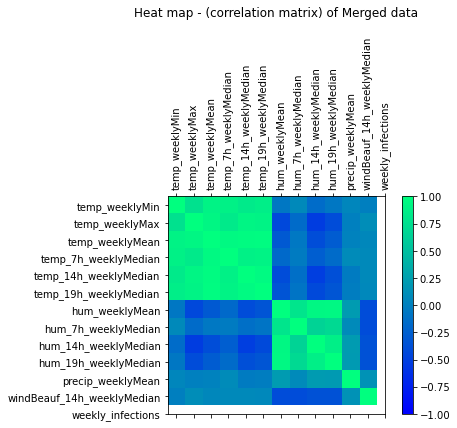

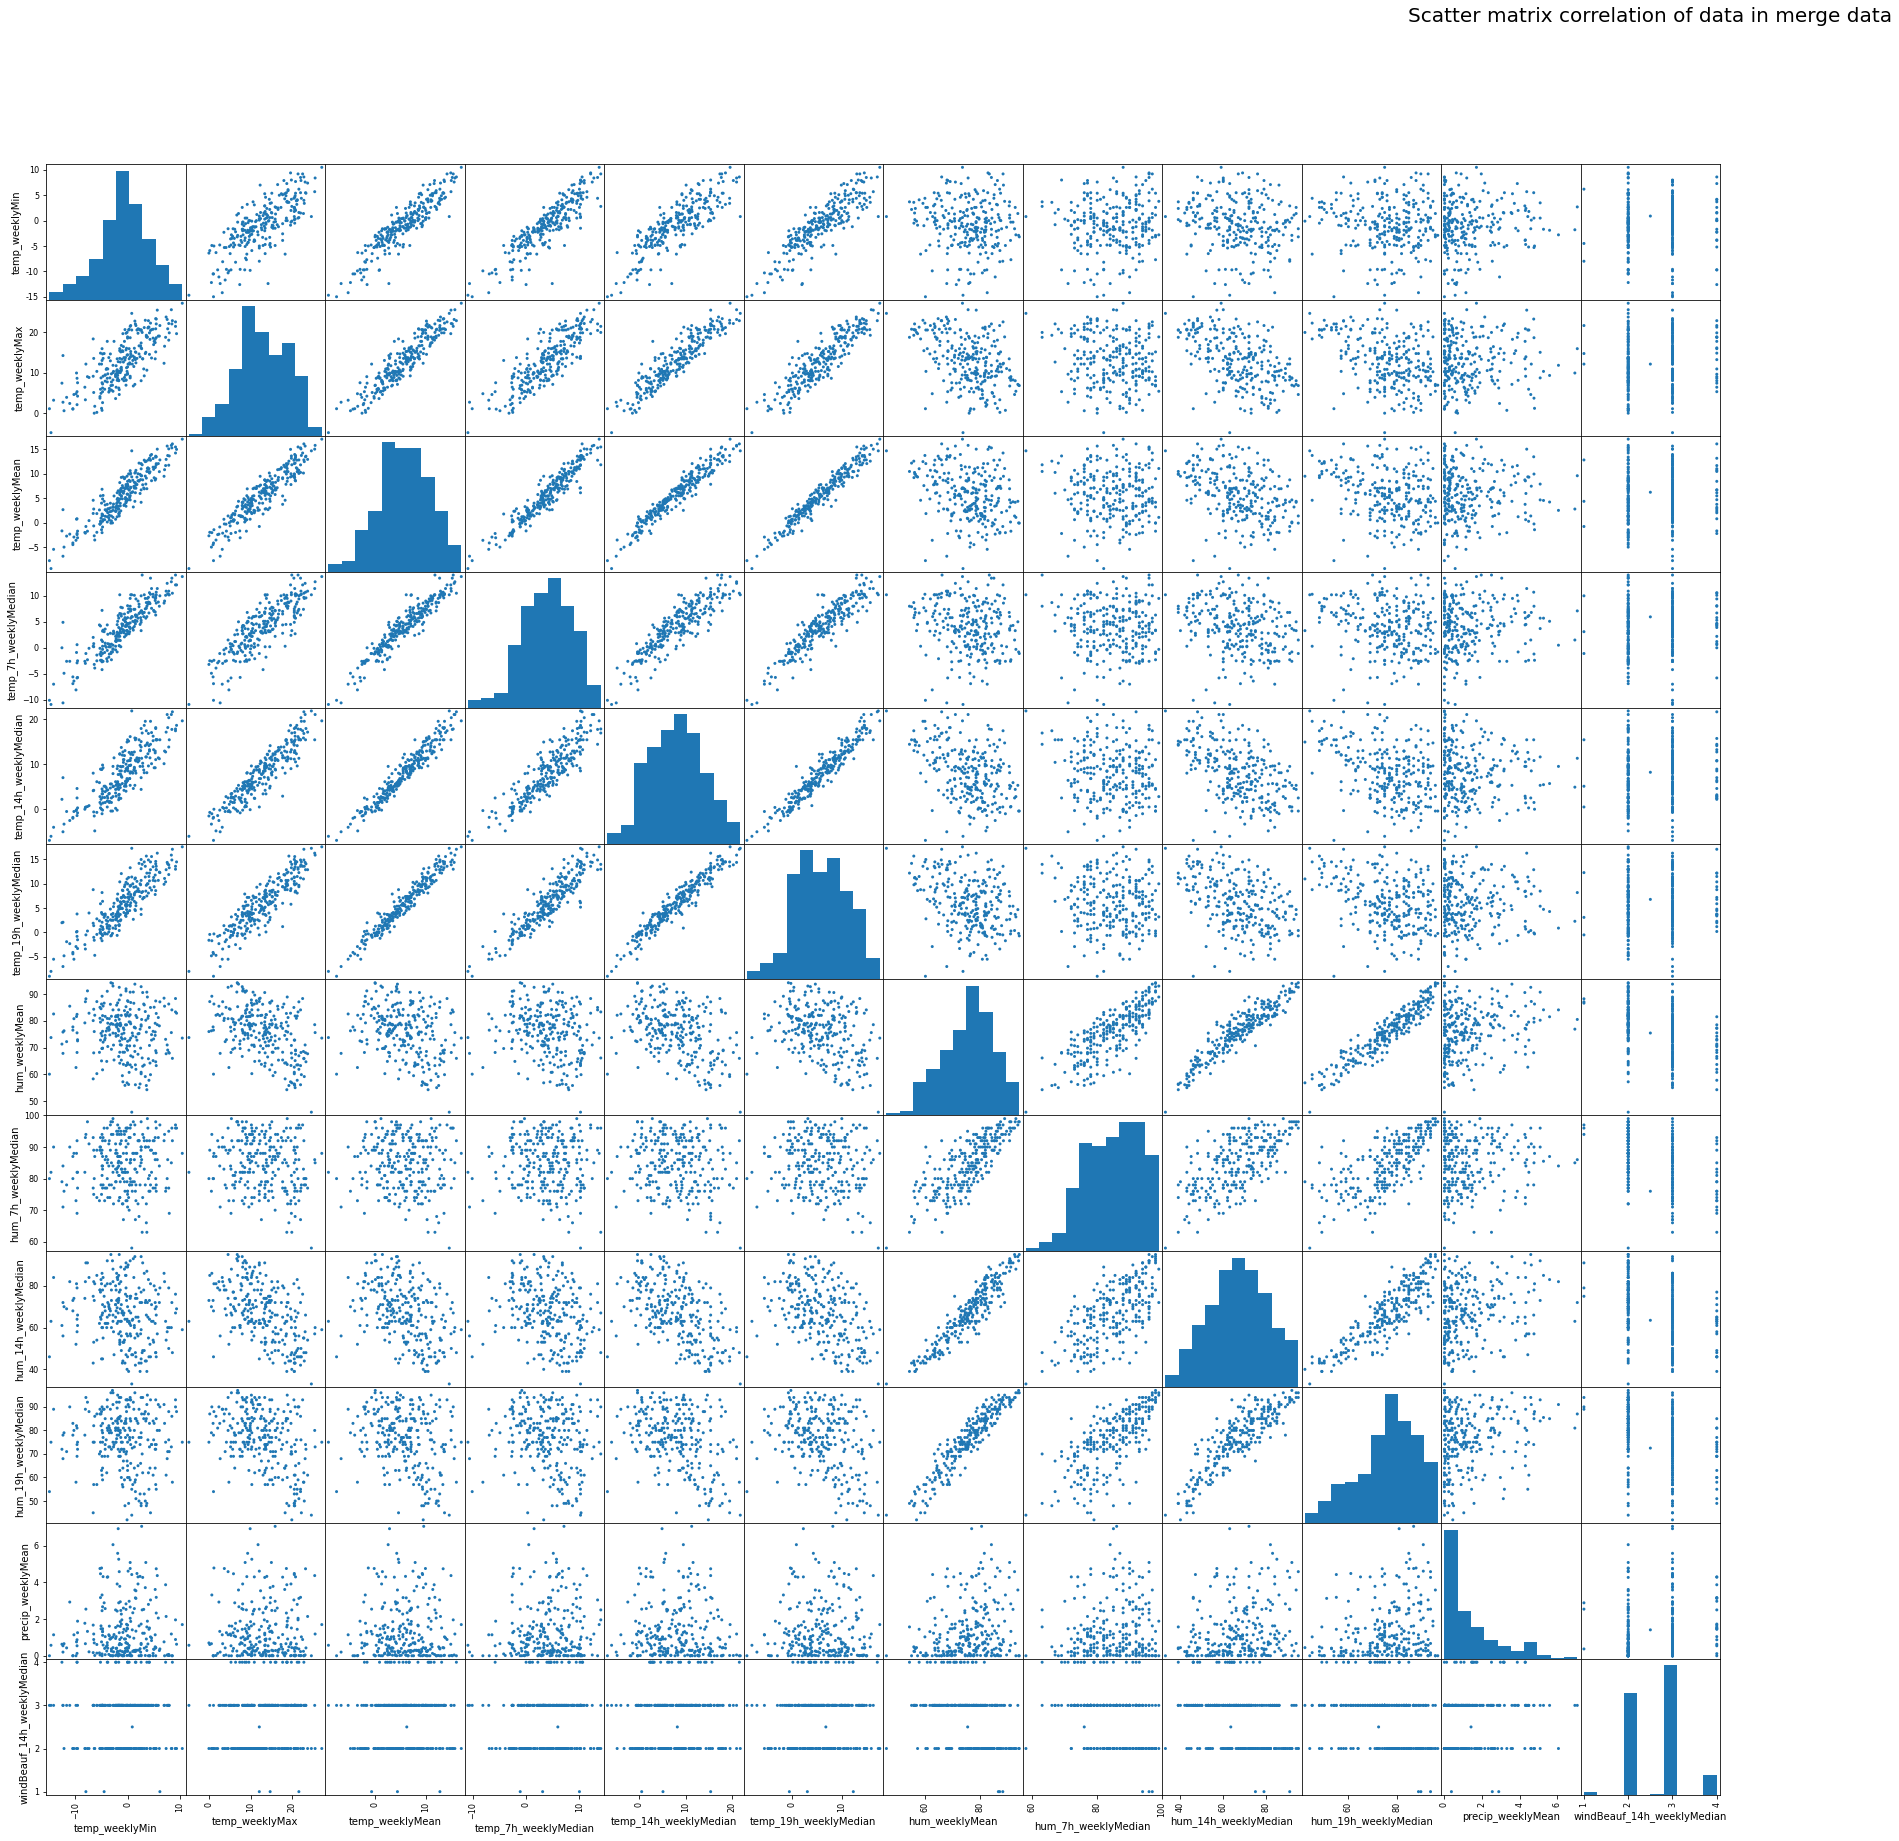

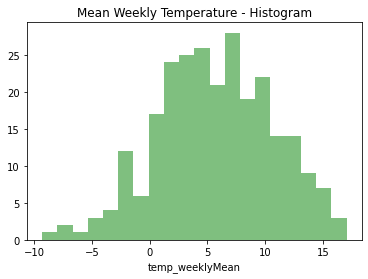

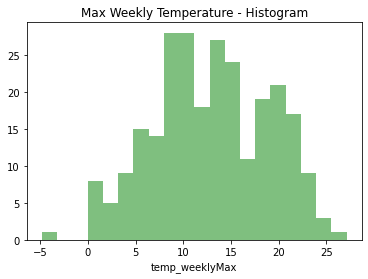

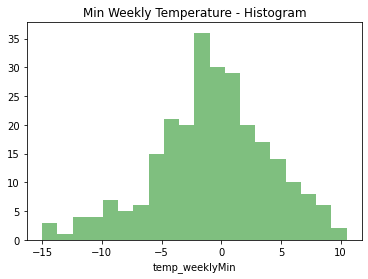

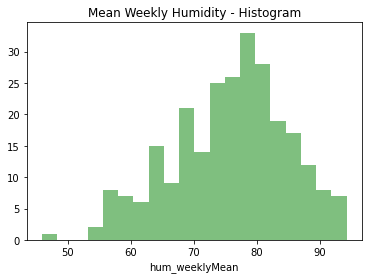

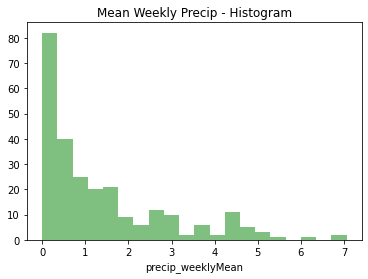

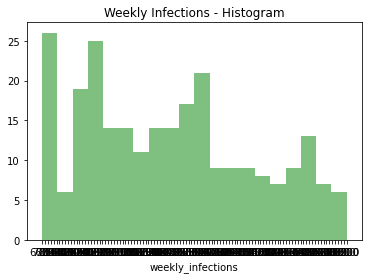

In [150]:
# YOUR CODE HERE
def heatMap(data,name):
    corr = data.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr,cmap='winter', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(data.columns),1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(data.columns)
    ax.set_yticklabels(data.columns)
    plt.title(name, y=1.8)
    plt.show()
    
def histogram(x, bins, xlab, name):
    plt.hist(x, bins=bins, facecolor='green', alpha=0.5)
    plt.xlabel(xlab)
    plt.title(name)
    plt.show()

def scatterMatrix(data,name):
    fig, size = plt.subplots(figsize=(30,30))
    Matrix = scatter_matrix(data, alpha=1, ax=size)
    plt.title(name, y=13, fontsize=20)
    plt.show()

heatMap(data_merged,'Heat map - (correlation matrix) of Merged data')
scatterMatrix(data_merged,'Scatter matrix correlation of data in merge data')
histogram(data_merged['temp_weeklyMean'], 20, 'temp_weeklyMean', 'Mean Weekly Temperature - Histogram')
histogram(data_merged['temp_weeklyMax'], 20, 'temp_weeklyMax', 'Max Weekly Temperature - Histogram')
histogram(data_merged['temp_weeklyMin'], 20, 'temp_weeklyMin', 'Min Weekly Temperature - Histogram')
histogram(data_merged['hum_weeklyMean'], 20, 'hum_weeklyMean', 'Mean Weekly Humidity - Histogram')
histogram(data_merged['precip_weeklyMean'], 20, 'precip_weeklyMean', 'Mean Weekly Precip - Histogram')
histogram(data_merged['weekly_infections'], 20, 'weekly_infections', 'Weekly Infections - Histogram')


#### Findings 
Summarize your findings.

For visualisation i used techniques such as heat map or correlaction matrix, scatter plots in scatter matrix and hit histograms. From the heat map we can see that correlation of the features where in the green color we have the features highly correlated and in the blue color the features that are less correlated, from this i can conclude that the features dealing with temp are highly correlated with each other the same goes to humidity features also, and in the other hand we have the weekly_infections which is not correlated. In the other hand this can be seen even more clearly from the scatter matrix where we have also the scater plots in between these features and we see that the correlated features have a uniform distribution of the data. 
One more analysation that i did is with visualisation of histograms for Mean weekly temperature, Max weekly temperature, Min weekly temperature, Weekly infections, mean weekly humidity, mean weekly precip. In these histograms we see that the data have a gausian aproximately bell shaped distribution of data exept for the mean weekly precip which has a very right skewed distribution and weekly infection which has a plateau distribution. 


YOUR ANSWER HERE

## Task 7: Influenza prediction model 
Total number of points for completing this task: **35**


Build a model to predict the number of influenza incidents for the first part of the 2019/<span style="color:red">2020</span> Influenza season (`influenza_predict.csv`) based on data of previous years using `sklearn`. 

 - Choose appropriate machine learning algorithm(s) for the problem at hand
 - Make sure your results are reproducible
 - Don't hesitate to go back to previous steps if you notice any data quality issues
 - If your chosen algorithm has specific parameters, explore their effect with different settings using 10-fold cross-validation
 - Experiment with different training/test splits
 - If appropriate, try different scaling approaches (min/max, z-score,..).
 - How good does your model fit when you evaluate it with the test data set?
 - How good are your predictions when you use the data entries in `influenza.csv` for 2019 as a validation set?
 - Present your results (e.g. by plotting predicted against true values)
 

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^KNN^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Nr of Neighbours:  3
Alg: auto
Mean Abs Error -MAE: 3522.666666666666
Mean Square error -MSE: 19462666.666666664
Root Mean Squar Error - RMSE: 4411.651240370964
/////////////////////////////////////////////////////////////////////////////////////////////////////////////////
Nr of Neighbours:  3
Alg: kd_tree
Mean Abs Error -MAE: 3064.0
Mean Square error -MSE: 14686933.333333332
Root Mean Squar Error - RMSE: 3832.3534979609244
/////////////////////////////////////////////////////////////////////////////////////////////////////////////////
Nr of Neighbours:  5
Alg: auto
Mean Abs Error -MAE: 2410.4
Mean Square error -MSE: 10666992.0
Root Mean Squar Error - RMSE: 3266.0361296225738
/////////////////////////////////////////////////////////////////////////////////////////////////////////////////
Nr of Neighbours:  5
Alg: kd_tree
Mean Abs Error -MAE: 2530.4
Mean Square error -MSE: 12453104.0
Root 

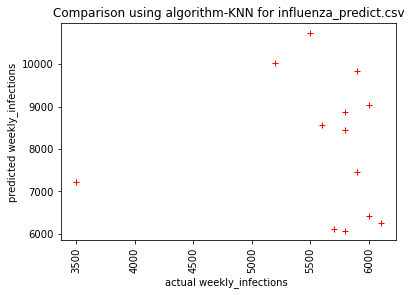

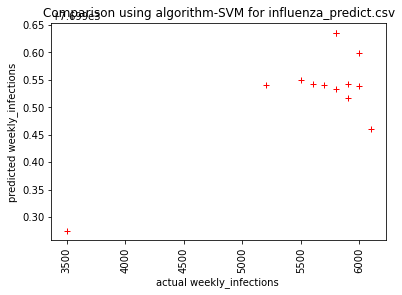

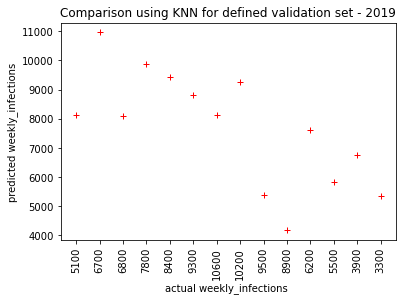

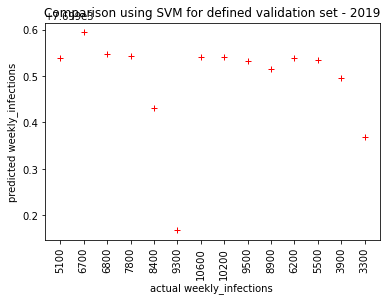

In [164]:
# YOUR CODE HERE
def prediction(Train_x_set, Test_x_set, Train_y_set, Valid_y, scale, regressor):
    Train_x_set = scale.fit_transform(Train_x_set)
    Test_x_set = scale.fit_transform(Test_x_set)
    regressor.fit(Train_x_set, Train_y_set)
    Y_predictionion = regressor.predict(Test_x_set)
    mae = mean_absolute_error(Valid_y, Y_predictionion)
    mse = mean_squared_error(Valid_y, Y_predictionion)
    rmse = sqrt(mean_squared_error(Valid_y, Y_predictionion))
    return mae, mse, rmse

def res(result):
    print("Mean Abs Error - MAE:", result[0])
    print("Mean Square error - MSE:", result[1])
    print("Root Mean Squar Error - RMSE:", result[2])

def visualisation(x,y,ax,ay,name):
    plt.plot(x, y, 'r+', label = 'prediction')
    plt.xlabel(ax)
    plt.xticks(rotation=90)
    plt.ylabel(ay)
    plt.title(name)
    plt.show()

def Kfold(Train_x_set, Train_y_set, hyppar_opt, res_hyppar, reg_get):
    hyppar_ind =0
    hyppar_len = len(hyppar_opt)
    kf = KFold(n_splits=hyppar_len, random_state=101)
    for train_i, test_i in kf.split(Train_x_set, Train_y_set):
        hyppar_tmp = hyppar_opt[hyppar_ind%hyppar_len]
        res_hyppar(hyppar_tmp)
        Train_x_set_tmp, Test_x_set_tmp = Train_x_set.iloc[train_i], Train_x_set.iloc[test_i]
        temp_Train_y_set, temp_Y_test = Train_y_set.iloc[train_i], Train_y_set.iloc[test_i]
        scale = MinMaxScaler()
        regressor = reg_get(hyppar_tmp)
        result = prediction(Train_x_set_tmp, Test_x_set_tmp, temp_Train_y_set, temp_Y_test, scale, regressor)
        res(result)
        print("/////////////////////////////////////////////////////////////////////////////////////////////////////////////////")
        hyppar_ind +=1
        

Valid_set = data_merged.loc[2019]
Train_set = data_merged.drop(index=2019)


Train_y_set = Train_set['weekly_infections'].astype(str).astype(int)
Train_x_set = Train_set.drop(columns='weekly_infections')




print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^KNN^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

def KNN_hyppar_print(hyppar_set):
    print("Nr of Neighbours: ", hyppar_set[0])
    print("Alg:", hyppar_set[1])
    
def KNN_reg(hyppar_set):
    regressor = KNeighborsRegressor(n_neighbors = hyppar_set[0], algorithm=hyppar_set[1])
    return regressor

KNN_hyppar = [[3, 'auto'], [3, 'kd_tree'], [5, 'auto'], [5, 'kd_tree'], [6, 'auto'], [6, 'kd_tree'],
                          [7, 'auto'], [7, 'kd_tree'], [9, 'auto'], [9, 'kd_tree']]
Kfold(Train_x_set, Train_y_set, KNN_hyppar, KNN_hyppar_print, KNN_reg)


print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^SVM^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

def SVM_hyppar_print(hyppar_set):
    print("Kernel: ", hyppar_set[0], "*")
    print("Gamma: ", hyppar_set[1], "*")
def SVM_reg(hyppar_set):
    regressor = SVR(kernel = hyppar_set[0], gamma=hyppar_set[1])
    return regressor

SVM_hyppar =[['linear','scale'], ['linear','auto'], ['poly', 'scale'], ['poly', 'auto'], ['rbf','scale'], ['rbf','auto'], 
                      ['sigmoid','scale'], ['sigmoid','auto']]
Kfold(Train_x_set, Train_y_set, SVM_hyppar, SVM_hyppar_print, SVM_reg)


print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^Valid Test^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
Valid_y = Valid_set['weekly_infections']
Valid_x = Valid_set.drop(columns='weekly_infections')

print("KNN")
KNNRegressor = KNeighborsRegressor(n_neighbors=5, algorithm='auto')
KNNRegressor.fit(Train_x_set, Train_y_set)
KNN_pred = KNNRegressor.predict(Valid_x)
mae = mean_absolute_error(Valid_y, KNN_pred)
mse = mean_squared_error(Valid_y, KNN_pred)
rmse = sqrt(mean_squared_error(Valid_y, KNN_pred))


KNN_res = [mae, mse, rmse]
res(KNN_res)

print("SVM")
svm = SVR(kernel = 'rbf', gamma='auto')
svm.fit(Train_x_set, Train_y_set)
SVM_pred = svm.predict(Valid_x)
mae = mean_absolute_error(Valid_y, SVM_pred)
mse = mean_squared_error(Valid_y, SVM_pred)
rmse = sqrt(mean_squared_error(Valid_y, SVM_pred))

svm_result = [mae, mse, rmse]

res(svm_result)

influenza_prediction = pd.read_csv('./data-corrected/data-corrected/influenza/influenza_predict.csv', delimiter = ",", thousands=".")[['Jahr','Kalenderwoche','Neuerkrankungen pro Woche']]
influenza_prediction = influenza_prediction.rename({'Neuerkrankungen pro Woche': 'weekly_infections', 'Jahr': 'year','Kalenderwoche': 'week'}, axis='columns')
influenza_prediction['week'] = influenza_prediction['week'].str.extract('(\d+)').astype(int)
influenza_prediction = influenza_prediction.set_index(['year', 'week'])
influenza_prediction = pd.concat([data_weather_weekly, influenza_prediction], axis=1,join ="inner")

last_y = influenza_prediction['weekly_infections']
last_x = influenza_prediction.drop(columns='weekly_infections')
print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^Last predictionions^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
print("KNN")
last_pred_knn = KNNRegressor.predict(last_x)
mae = mean_absolute_error(last_y, last_pred_knn).astype(int)
mse = mean_squared_error(last_y, last_pred_knn)
rmse = sqrt(mean_squared_error(last_y, last_pred_knn))

last_res_knn= [mae, mse, rmse]
res(last_res_knn)
print("SVM")
last_pred_svm = svm.predict(last_x)
mae = mean_absolute_error(last_y, last_pred_svm).astype(int)
mse = mean_squared_error(last_y, last_pred_svm)
rmse = sqrt(mean_squared_error(last_y, last_pred_svm))

last_res_svm= [mae, mse, rmse]
res(last_res_svm)

visualisation(last_y,last_pred_knn,'actual weekly_infections ','predicted weekly_infections','Comparison using algorithm-KNN for influenza_predict.csv')
visualisation(last_y,last_pred_svm,'actual weekly_infections ','predicted weekly_infections','Comparison using algorithm-SVM for influenza_predict.csv')
visualisation(Valid_y,KNN_pred,'actual weekly_infections ','predicted weekly_infections','Comparison using KNN for defined validation set - 2019')
visualisation(Valid_y,SVM_pred,'actual weekly_infections ','predicted weekly_infections','Comparison using SVM for defined validation set - 2019')





#### Approach and algorithm
Motivate your approach and choice of algorithm in the cell below

YOUR ANSWER HERE

To build the prediction models i tried two different algorithms such as K neares neighbours(KNN) and Support vector machines(SVM)i choosed these two taking into cosideration the fact that they differe in the way they predict, KNN regression is based in distance and SVM are based on classification mapping of data. 

For comparison of the models and for performance accurance i used methods such as MAE- mean absolute error, MSE- mean squared error and RMSE- root mean squared error.

Important to note that i also used a scailing of data and for this purpose i used minmax scailing method. 

To see how good are the predictions as we where advised in the request i used data that where in the influenca.csv belonging in year 2019 as a validation set and the rest was used as a training set. This validation and test set was used to see which algorithm performed best, but in order to do so i also added some hyperparameters for the particular algorithms which i tried to optimise in order to get the best results. 

In order to conclude which hyperparameters where the best ones for the specific algorithm a k-fold cross validation with k=10 was used, so in each algorithm 10 different hyperparameters where used. This was the form used for hyperparameter optimisation.

After several checks and computations i concluded that the best results for the specific algorithms used where obtained with the parameters below:

-> KNN - n_neighbours = 4, algorithm= auto
-> SVM - kernel = rbf, gamma = auto

Now using the validation set defined we tested our two algorithms and the best results where obtained with the KNN algorithm than the SVN ones, this was concluded taking into consideration also the results from MSE, MAE, RMSE. So for the final predictions the KNN algorithm was picked. Also a visualisation between actual and predicted values was provided for specific cases.



#### Findings 
Summarize your findings and lessons learned.




First it was a quite challenging exercise considering my experience with python, in the other hand the exercise was very interesting and actually i was learning more and more everyday that i was working on it.
This exercise as a jurney was quite tough but also fun and interesting, i had a lot of challeges but in the end i figured a nice approach on it, and most importantly i gained a lot of knowledge in data preprocesing, visualizations, conlncusions and building also comparing different algorithms in model. 

One of the lessons which i think its quite important also in future is working with multi-indexing feature from pandas. 
As i loaded the data in proper format i started to handle the missing values, in this exercise i realised how important is the handling of missing values step in building a proper model, well i saw that it is quite difficult and also important to keep a balance between imputation and deletation of data which later might impact inaccurancies in model. 
An important step was also the use of simple approaches in imputation comparing to more serious and advance approaches. In my case the advanced method of handling missing values had a better impact in model comparing to simple approach, also in personal perspective it was more challenging to deal with it because there are not much build in functions in python so i had to have first a proper idea and then to imprement it which also tested a lot my programming skills in data science. 

Another important aspect before building and testing the models was the visualisation step. Important to note that a proper visualisation tells a lot of information for the data which is very crucial and useful in building an accurate model. Through visualisation i was able to see the distribution of data, correlation of features which told me which features have a huge impact in the results, relations and differences between specific features in the data which are useful later on in prediction data and also in specific alforithms for prediction. A very important fact that we need to notify, and that i was able to see it through a proper visualisation was the fact that temperature feature and weekly infections have a negative correlation in between which lets us know that when we have high values of temperature we expect a decrease in the value for weekly infections.

Now after we have done a proper preprocessing step with data which contains analysation of dataset, clearance of dataset from missing values, handling properly the outliers any potential merging and formating of data it was time to start and thing about which algorithms are we going to use so i decided to take into consideration KNN(K nearest neighbours) and SVM(support vector machines) i decided to pick two algorithms in order to have a chance to really compare some output of algorithms in between. 
After picking the algorithms there are quite important steps to be defined before we start to build our model to get some predictions, these steps contain train and test spliting first within which i tried to fulfill the requests from the explonation that was provided to us through the exercise. 
Another important step now to get the best from the algorithms was the definition of hyperparameters which have quite a big impact on model behaviour and performance so we need to be very careful on techniques we are using to do a hyperparameter optimisation. 
I didnt see a very hudge impact on scailing technique in accurance of the model maybe this is because we handle quite properly the missing values and the outliers, never the less scailing is an important step taking into consideration the fact that it reduces the impact of outliers in model performance.  

Overall it was a very good oppertunity to learn a lot for data handling and building model. As a lesson learned i would mention that i created a strategy for myself as a data scienties how to handle data from zero to a nice model creation for prediction. Honestly thank you for the oppertunity, i learned a lot thorugh this exercise.